## Find distinguishing properties of modalities

In [11]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style='ticks', context='talk', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline



import flotilla

flotilla_dir = '/projects/ps-yeolab/obotvinnik/flotilla_projects'

folder = 'figures' #'/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_modalities/bayesian'

study = flotilla.embark('singlecell_pnm_figure2_modalities_bayesian', flotilla_dir=flotilla_dir)

not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-05-25 12:02:32	Reading datapackage from /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_figure2_modalities_bayesian/datapackage.json
2016-05-25 12:02:32	Parsing datapackage to create a Study object
2016-05-25 12:03:19 	Initializing Study
2016-05-25 12:03:19 	Initializing Predictor configuration manager for Study
2016-05-25 12:03:19	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-05-25 12:03:19	Added ExtraTreesClassifier to default predictors
2016-05-25 12:03:19	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-05-25 12:03:19	Added ExtraTreesRegressor to default predictors
2016-05-25 12:03:19	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-05-25 12:03:19	Added GradientBoostingClassifier to default pred

In [12]:
splicing_singles_no_outliers = study.splicing.singles.ix[not_outliers]


### Modality bar graph of events inconsistent with pooled

In [13]:
modalities_inconsistent = study.percent_pooled_inconsistent(
    feature_subset=study.supplemental.modalities_tidy.event_id.unique())

In [14]:
pooled_inconstent_folder = '{}/pooled_inconsistent_delta_psi'.format(folder)
! mkdir $pooled_inconstent_folder

In [15]:
from flotilla.visualize.generic import cdfplot

singles_grouped = study.splicing.singles.groupby(study.sample_id_to_phenotype)
pooled_grouped = study.splicing.pooled.groupby(study.sample_id_to_phenotype)

bins = np.arange(0, 1.05, 0.05)

min_difference = 0.1

pooled_inconsistent_dir = '{}/pooled_inconsistent'.format(folder)
! mkdir $pooled_inconsistent_dir

mean_diff_dfs = []

for (phenotype, modality), df in study.supplemental.modalities_tidy.groupby(['phenotype', 'modality']):
    singles = singles_grouped.get_group(phenotype).ix[:, df.event_id].dropna(how='all',axis=1)
    pooled = pooled_grouped.get_group(phenotype).ix[:, df.event_id].dropna(how='all', axis=1)
    
    singles, pooled = singles.align(pooled, axis=1, join='inner')
    mean_difference = pooled.apply(lambda x: singles.subtract(x, axis=1).abs().mean(axis=0), axis=1)
    
    mean_diff_df = mean_difference.unstack().reset_index()
    mean_diff_df['phenotype'] = phenotype
    mean_diff_df['modality'] = modality
    mean_diff_dfs.append(mean_diff_df)
    
    events = mean_difference.columns[(mean_difference > min_difference).any(axis=0)]
#     for event in events:
#         gene_name = study.splicing.feature_data.gene_name[event]
#         study.plot_event(event, sample_subset='~outlier')
#         fig = plt.gcf()
#         fig.savefig('{}/{}_{}_{}_{}.pdf'.format(
#                 pooled_inconsistent_dir, modality, phenotype, gene_name, event))
    
mean_diff_df = pd.concat(mean_diff_dfs)
mean_diff_df = mean_diff_df.rename(columns={0: 'mean diff', 'level_0': 'event_id', 
                                            'level_1':'pooled_id'})

In [16]:
mean_diff_df.groupby(['phenotype', 'modality']).apply(lambda x: 100*(x['mean diff'] > min_difference).sum()/float(x.shape[0]))

phenotype  modality     
MN         bimodal           56.922258
           excluded           7.611549
           included           4.604741
           uncategorized    100.000000
NPC        bimodal           47.599514
           excluded           4.495485
           included           3.069981
           uncategorized     91.666667
iPSC       bimodal           41.569642
           excluded           4.440542
           included           2.688172
           middle           100.000000
           uncategorized    100.000000
dtype: float64

In [17]:
from anchor import MODALITY_ORDER, MODALITY_PALETTE, MODALITY_TO_COLOR

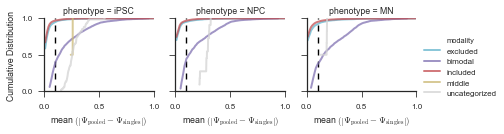

In [19]:
sns.set(context='paper', style='ticks')
g = sns.FacetGrid(mean_diff_df, col='phenotype', col_order=study.phenotype_order, hue='modality', size=2,
                  hue_order=MODALITY_ORDER, palette=MODALITY_PALETTE, legend_out=True)
g.map(cdfplot, 'mean diff', log=False, alpha=0.75, linewidth=2)

g.set(ylim=(0, 1))
for ax in g.axes.flat:
    ax.locator_params(nbins=4)
    if ax.is_first_col():
        ax.set_ylabel('Cumulative Distribution')
    xmin, xmax, ymin, ymax = ax.axis()
    ax.vlines(min_difference, ymin, ymax, linestyle='--')
    ax.set(xlim=(0, xmax), 
           xlabel=r'mean $\left(\left|\Psi_{\mathrm{pooled}} - \Psi_{\mathrm{singles}}\right|\right)$')
g.fig.tight_layout()
g.add_legend();
g.savefig('{}/modality_pooled_inconsistent_cdf.pdf'.format(pooled_inconstent_folder))

In [20]:
mean_diff_df_01 = mean_diff_df.loc[mean_diff_df['mean diff'] >= min_difference]

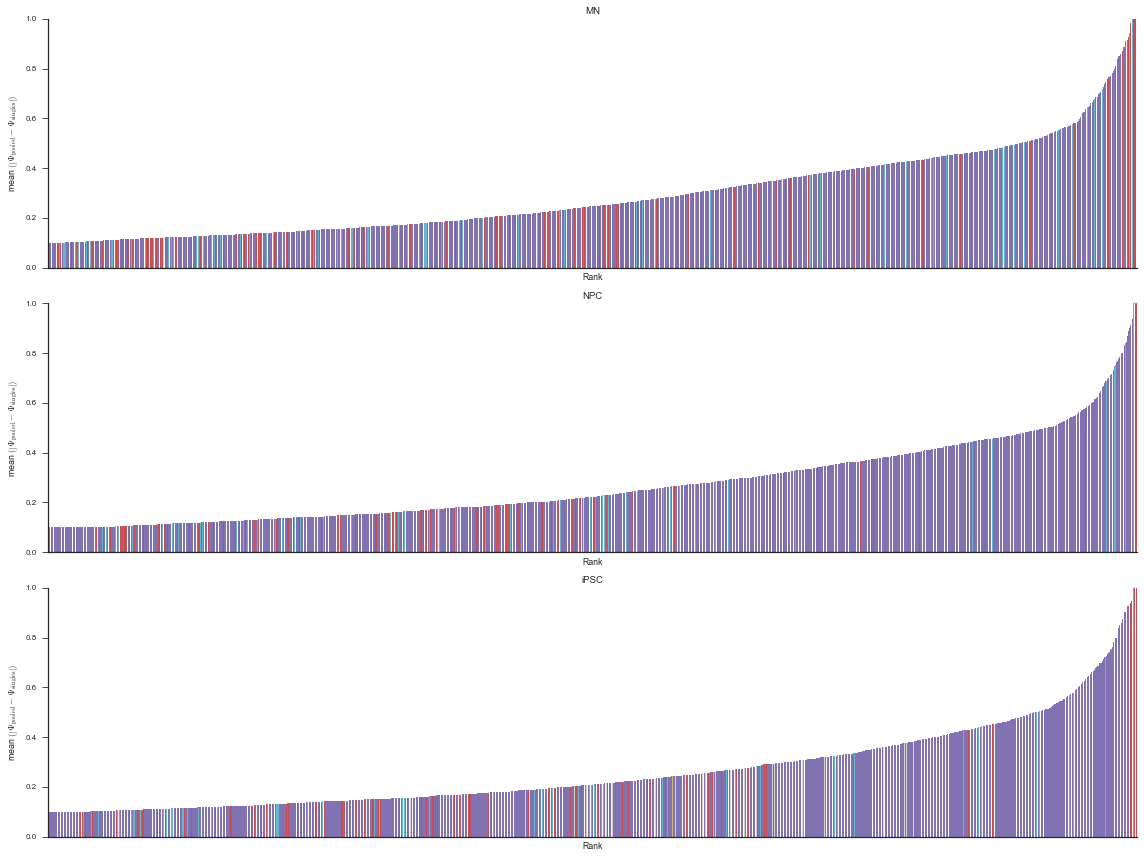

In [21]:
fig, axes = plt.subplots(figsize=(16, 12), nrows=3)

ylabel = r'mean $\left(\left|\Psi_{\mathrm{pooled}} - \Psi_{\mathrm{singles}}\right|\right)$'

for ax, (phenotype, phenotype_df) in zip(axes, mean_diff_df_01.groupby('phenotype')):
    phenotype_df['mean diff rank'] = phenotype_df['mean diff'].rank(method='first')
    for modality, modality_df in phenotype_df.groupby('modality'):
        x = modality_df['mean diff rank']
        y = modality_df['mean diff']
        color = MODALITY_TO_COLOR[modality]
        ax.bar(x, y, color=color, linewidth=0)
    xmax = phenotype_df['mean diff rank'].max() + 1
    
    ax.set(xlim=(0, xmax), xlabel='Rank', title=phenotype, ylabel=ylabel, xticks=[])
    sns.despine()
#     df = df.sort_values('mean diff')
fig.tight_layout()
fig.savefig('{}/delta_psi_ranked_barplot.pdf'.format(pooled_inconstent_folder))

In [22]:
study.supplemental.splicing_singles_vs_pooled = mean_diff_df

In [23]:
mean_diff_df.head()

,event_id,pooled_id,mean diff,phenotype,modality
0,exon:chr10:101480744-101480825:-@exon:chr10:10...,M2_05,NaN,MN,bimodal
1,exon:chr10:101480744-101480825:-@exon:chr10:10...,M2nd_13,0.052632,MN,bimodal
2,exon:chr10:101480744-101480825:-@exon:chr10:10...,M2nd_21,0.052632,MN,bimodal
3,exon:chr10:102747070-102747240:-@exon:chr10:10...,M2_05,0.183352,MN,bimodal
4,exon:chr10:102747070-102747240:-@exon:chr10:10...,M2nd_13,0.202275,MN,bimodal


In [24]:
mean_diff_df02 = mean_diff_df.loc[mean_diff_df['mean diff'] > 0.2]
mean_diff_df02.shape

(5200, 5)

In [25]:
mean_diff_02_modalities = mean_diff_df02.groupby('modality').size()
mean_diff_02_modalities

modality
bimodal          4482
excluded          264
included          382
middle              2
uncategorized      70
dtype: int64

In [26]:
mean_diff_02_modalities.sum()

5200

In [27]:
mean_diff_02_modalities_percentage = 100*mean_diff_02_modalities/mean_diff_02_modalities.sum()
mean_diff_02_modalities_percentage.head()

modality
bimodal          86.192308
excluded          5.076923
included          7.346154
middle            0.038462
uncategorized     1.346154
dtype: float64

In [28]:
percent_col = '%'.format()
x_col = 'of {} events with $|\Delta\Psi| > {:.2f}$'.format(mean_diff_02_modalities.sum(), min_difference)

mean_diff_02_modalities_percentage_df = mean_diff_02_modalities_percentage.reset_index()
mean_diff_02_modalities_percentage_df = mean_diff_02_modalities_percentage_df.rename(
    columns={0: percent_col})
mean_diff_02_modalities_percentage_df['x'] = x_col
mean_diff_02_modalities_percentage_df

,modality,%,x
0,bimodal,86.192308,of 5200 events with $|\Delta\Psi| > 0.10$
1,excluded,5.076923,of 5200 events with $|\Delta\Psi| > 0.10$
2,included,7.346154,of 5200 events with $|\Delta\Psi| > 0.10$
3,middle,0.038462,of 5200 events with $|\Delta\Psi| > 0.10$
4,uncategorized,1.346154,of 5200 events with $|\Delta\Psi| > 0.10$


In [29]:
sns.set(style='ticks', context='paper')

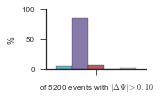

In [30]:
g = sns.factorplot(hue='modality', hue_order=MODALITY_ORDER, palette=MODALITY_PALETTE,
               x='x', y=percent_col, size=1.5, legend=False, aspect=1.5,
               data=mean_diff_02_modalities_percentage_df, kind='bar')
g.set(xlabel='')
for ax in g.axes.flat:
    ax.locator_params(nbins=4, axis='y')
g.fig.tight_layout()
g.savefig('{}/percent_delta_psi_greater_02_modality.pdf'.format(pooled_inconstent_folder))

In [31]:
# mean_diff_percentage = mean_diff_df.groupby(['phenotype', 'modality']).apply(
#     lambda x: 100.*(x['mean diff'] > min_difference).sum()/x.shape[0])
# mean_diff_percentage = mean_diff_percentage.reset_index()
# mean_diff_percentage = mean_diff_percentage.rename(columns={0: 'Percent single-cell events\ninconsistent with pooled'})
# g = sns.factorplot(x='phenotype', y='Percent single-cell events\ninconsistent with pooled', hue='modality',
#                    data=mean_diff_percentage, kind='bar', size=3, aspect=1.25, legend=False, **modality_factorplot_kws)
# for ax in g.axes.flat:
#     ax.locator_params('y', nbins=4)
# g.fig.tight_layout()
# g.add_legend();

# g.savefig('{}/modality_pooled_inconsistent_percentage.pdf'.format(folder))